In [0]:
import subprocess
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))
  
def detect_env():
    import os
    if 'content' in os.listdir('/'):
      return "colab"
    else:
      return "IBM"
    
def create_env():
  if detect_env() == "IBM":
    return IBMEnv()
  elif detect_env() == "colab":
    return ColabEnv()


class Env():
  def get_nag_util_files(self):
      import os
      
      print("\ngetting git files ...")
      if os.path.isdir(self.python_files_path):
        os.chdir(self.python_files_path)
        run_shell_command('git pull')
        os.chdir(self.root_folder)
      else:
        run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')
      print("done.")
  

class IBMEnv:
    def __init__(self):
      self.root_folder = ""
      raise NotImplementedError("root folder address")
      self.temp_csv_path = self.root_folder + "/temp"
      self.python_files_path = self.root_folder + "/nag-public"
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      
      import sys
      sys.path.append('./nag/nag_util')
      
    def get_csv_path(self):
      return self.root_folder + "/textual notes/CSVs/" + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/models/" + self.save_filename
      
    def setup(self):
      self.get_nag_util_files()
      
    def load_dataset(self, compressed_name, unpacked_name):
      pass
    
    def set_data_path(self, path):
      self.data_path = self.root_folder + '/datasets/' + path
        
class ColabEnv(Env):
    def __init__(self):
      self.root_folder = '/content'
      self.temp_csv_path = self.root_folder
      self.python_files_path = self.root_folder + '/nag-public'
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      self.torchvision_upgraded = False
      
    def get_csv_path(self):
      return self.root_folder + '/gdrive/My Drive/DL/textual notes/CSVs/' + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/gdrive/My Drive/DL/models/" + self.save_filename
        
    def setup(self):
        # ######################################################
        # # TODO remove this once torchvision 0.3 is present by
        # # default in Colab
        # ######################################################
        if not self.torchvision_upgraded:
          !pip uninstall -y torchvision
          !pip install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
          self.torchvision_upgraded = True
        else:
          print("torchvision already upgraded")
          
        
        drive.mount('/content/gdrive')
        
        self.get_nag_util_files()
        
    def load_dataset(self, compressed_name, unpacked_name):
      if compressed_name not in os.listdir('.'):
        print(compressed_name + ' not found, getting it from drive')
        shutil.copyfile("/content/gdrive/My Drive/DL/{}.tar.gz".format(compressed_name), "./{}.tar.gz".format(compressed_name))

        gunzip_arg = "./{}.tar.gz".format(compressed_name)
        !gunzip -f $gunzip_arg

        tar_arg = "./{}.tar".format(compressed_name)
        !tar -xvf $tar_arg > /dev/null

        os.rename(unpacked_name, compressed_name)

    #     ls_arg = "./{}/train/n01440764".format(compressed_name)
    #     !ls $ls_arg

        !rm $tar_arg

        print("done") 
      else:
        print(compressed_name + " found")
        
    def set_data_path(self, path):
      self.data_path = './' + path
        

In [0]:
if detect_env() == "colab":
  from google.colab import drive
    
env = create_env()

In [3]:
env.setup()

Uninstalling torchvision-0.3.0:
  Successfully uninstalled torchvision-0.3.0
  Using cached https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

getting git files ...
Already up to date.

done.


In [0]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil
sys.path.append(env.python_files_path + '/' + env.python_files_dir)


from nag_util import *
import nag_util

In [0]:
def load_dataset_to_colab(compressed_name, unpacked_name):
  if compressed_name not in os.listdir('.'):
    print(compressed_name + ' not found, getting it from drive')
    shutil.copyfile("/content/gdrive/My Drive/DL/{}.tar.gz".format(compressed_name), "./{}.tar.gz".format(compressed_name))
    
    gunzip_arg = "./{}.tar.gz".format(compressed_name)
    !gunzip -f $gunzip_arg
        
    tar_arg = "./{}.tar".format(compressed_name)
    !tar -xvf $tar_arg > /dev/null
    
    os.rename(unpacked_name, compressed_name)
    
#     ls_arg = "./{}/train/n01440764".format(compressed_name)
#     !ls $ls_arg
    
    !rm $tar_arg
    
    print("done") 
  else:
    print(compressed_name + " found")
    
def load_test_dataset(root_folder):
  test_folder = root_folder + '/test/'
  if 'test' not in os.listdir(root_folder):
    os.mkdir(test_folder)
    for i in range(1,11):
      shutil.copy("/content/gdrive/My Drive/DL/full_test_folder/{}.zip".format(i), test_folder)
      shutil.unpack_archive(test_folder + "/{}.zip".format(i), test_folder)
      os.remove(test_folder + "/{}.zip".format(i))
      print("done with the {}th fragment".format(i))

In [0]:
# mode = "sanity_check"
mode = "normal"

In [7]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')

dataset found


In [0]:
batch_size = 8
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
# nag_util.set_globals(gpu_flag, batch_size)
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder()
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [0]:
# model = models.resnet50
model = models.vgg16_bn
# model = torchvision.models.googlenet
model_name = model.__name__
z_dim = 10

class SoftmaxWrapper(nn.Module):
  def __init__(self, m):
    super().__init__()
    self.m = m
    self.softmax = nn.Softmax(dim=-1)
    
  def forward(self, inp):
    out = self.m(inp)
    return self.softmax(out)
  
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

# resnet:
# layers = [
#   arch.layer2[0].downsample,
#   arch.layer3[0].downsample,
#   arch.layer4[0].downsample
# ]
layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# layers = []
# last_layer = None
# for o in children(arch):
#   if isinstance(o, nn.AdaptiveAvgPool2d):
#     layers.append(last_layer)
#   last_layer = o
    
# # layers = [arch.fc]

# layer_weights = [1] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [0]:
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, 
                             self.gf_dim * 4,
                              k_size = (5,5), s = (2,2), pad = (2,2))
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)

    self.half = self.gf_dim // 2
    if self.half == 0:
      self.half == 1
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)

    self.quarter = self.gf_dim // 4
    if self.quarter == 0:
      self.quarter == 1
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)

    self.eighth = self.gf_dim // 8
    if self.eighth == 0:
      self.eighth == 1
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

    # sixteenth = self.gf_dim // 16
    # if half == 0:
      # half == 1
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

    # sixteenth = self.gf_dim // 16
    # if half == 0:
      # half == 1
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)


  def forward_z(self, z):
    self.bs = z.shape[0]
      
    # define generator here
    # input: bs * 100
    # Linear (z_dim, gf_dim * 7 * 4 * 4), bias = (True, init with zero), 
    # Reshape (bs, gf_dim * 7 * 4 * 4) -> (bs, gf_dim * 7, 4 , 4)
    # Virtual Batch Norm = VBN
    # ReLU
    # h0 <- relu output
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    # h0z = self.make_z([bs, gf_dim, 4, 4])
    # h0 = torch.cat([h0, h0z], dim=1)
    # h1 = deconv(gf_dim * 8, gf_dim * 4, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h1 = ReLU(VBN(h1))
    h0z = self.make_z([self.bs, self.gf_dim, 4, 4])
    h0 = torch.cat([h0, h0z], dim=1)
    h1 = self.CT2d_1(h0)
    assert h1.shape[2:] == (7, 7), "Non-expected shape, it shoud be (7,7)"

    # h1z = self.make_z([bs, gf_dim, 7, 7])
    # h1 = torch.cat([h1, h1z], dim=1)
    # h2 = deconv(gf_dim * 5, gf_dim * 2, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h2 = ReLU(VBN(h2))
    # assert output size (14,14)
    h1z = self.make_z([self.bs, self.gf_dim, 7, 7])
    h1 = torch.cat([h1, h1z], dim=1)
    h2 = self.CT2d_2(h1)
    assert h2.shape[2:] == (14,14), "Non-expected shape, it shoud be (14,14)"

    # h2z = self.make_z([bs, half, 14, 14])
    # h2 = torch.cat([h2, h2z], dim=1)
    # h3 = deconv(gf_dim  2 + half, gf_dim  1, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h3 = ReLU(VBN(h3))
    h2z = self.make_z([self.bs, self.half, 14, 14])
    h2 = torch.cat([h2, h2z], dim=1)
    h3 = self.CT2d_3(h2)
    assert h3.shape[2:] == (28,28), "Non-expected shape, it shoud be (28,28)"

    # h3z = self.make_z([bs, quarter, 28, 28])
    # h3 = torch.cat([h3, h3z], dim=1)
    # h4 = deconv(gf_dim * 1 + quarter, gf_dim * 1, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h4 = ReLU(VBN(h4))
    h3z = self.make_z([self.bs, self.quarter, 28, 28])
    h3 = torch.cat([h3, h3z], dim=1)
    h4 = self.CT2d_4(h3)
    assert h4.shape[2:] == (56,56), "Non-expected shape, it shoud be (56,56)"

    # h4z = self.make_z([bs, self.eighth, 56, 56])
    # h4 = torch.cat([h4, h4z], dim=1)
    # h5 = deconv(gf_dim * 1 + eighth, gf_dim * 1, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h5 = ReLU(VBN(h5))

    h4z = self.make_z([self.bs, self.eighth, 56, 56])
    h4 = torch.cat([h4, h4z], dim=1)
    h5 = self.CT2d_5(h4)
    assert h5.shape[2:] == (112,112), "Non-expected shape, it shoud be (112,112)"

    # h5z = self.make_z([bs, eighth, 112, 112])
    # h5 = torch.cat([h5, h5z], dim=1)
    # h6 = deconv(gf_dim * 1 + eighth, gf_dim * 1, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h6 = ReLU(VBN(h5))
    h5z = self.make_z([self.bs, self.eighth, 112, 112])
    h5 = torch.cat([h5, h5z], dim=1)
    h6 = self.CT2d_6(h5)
    assert h6.shape[2:] == (224,224), "Non-expected shape, it shoud be (224,224)"

    # h6z = self.make_z([bs, eighth, 224, 224])
    # h6 = torch.cat([h6, h6z], dim=1)
    # h7 = deconv(gf_dim * 1 + eighth, 3, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h7 = ReLU(VBN(h7))
    h6z = self.make_z([self.bs, self.eighth, 224, 224])
    h6 = torch.cat([h6, h6z], dim=1)
    h7 = self.CT2d_7(h6)
    assert h7.shape[2:] == (224,224), "Non-expected shape, it shoud be (448,448)"

    # out = 10*tanh(h7)

    #     return 10 *F.tanh(h7)
    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)
    # return 0.15 * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]
    z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
    p, n = self.make_triplet_samples(z, 0.1, 2., 5.)
    
    z_out = self.forward_z(z)
    p_out = self.forward_z(p)
    n_out = self.forward_z(n)
    
    return z_out, p_out, n_out, inputs
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     negative_sample = z + self.random_vector_volume(z.shape, margin, margin * scale).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

#   def random_vector_volume(shape, inner_r = 0, outer_r):
#     d = torch.zeros(shape[0]).uniform_()   ** (1/int(np.prod(shape[0])))
#     d.unsqueeze_(-1)
#     return random_vector_surface(shape, outer_r) * d
  
  def random_vector_volume(self, shape, inner_r, outer_r):
#     d = torch.zeros(shape[0]).uniform_(0, outer_r - inner_r).cuda()
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * d + inner_r
    return self.random_vector_surface(shape, 1) * fraction

   
  def make_z(self, in_shape):
    result = torch.empty(in_shape).uniform_(-1,1).cuda()
    return self.move_gpu(result)

  def move_gpu(self, inp):
    if gpu_flag:
        return inp.cuda()
    else:
        return inp


In [0]:
def load_starting_point(learn, name, z_dim):
  if detect_env() != "colab":
    raise NotImplementedError("load_starting_point not implemented for non-colab environments yet.")
  import os
  identity_token = name + '-zdim' + str(z_dim)
  address = '/content/gdrive/My Drive/DL/model_starting_points/' + identity_token
  starting_point_exists = os.path.isfile(address + '.pth')
  if not starting_point_exists:
    print("\n\nno starting point found for model:" + identity_token + ". creating one from the current learner.\n\n")
    learn.save(address)
  learn.load(address)

In [0]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  return F.kl_div(x1, x2)

def wasserstein_distance(x1, x2):
  pass

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def triplet_loss(anchor, positive, negative, distance_func, margin = 0.1):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
  return torch.mean(F.relu(distance_func(anchor, positive) - distance_func(anchor, negative) + margin))

In [0]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(torch.nn.functional.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))

In [0]:
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        # define generator here 
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
        self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_loss']# Maybe Gram
        self.triplet_weight = 20
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
    
#     def forward(self, inp, target):
#         sigma_B, sigma_pos, sigma_neg, X_B = inp

#         X_A = self.add_perturbation(X_B, sigma_B) 
#         X_A_pos = self.add_perturbation(X_B, sigma_pos)
#         X_A_neg = self.add_perturbation(X_B, sigma_neg) 
        
#         X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples
        
#         B_Y, _ = self.make_features(X_B)
#         A_Y, A_feat = self.make_features(X_A)
#         _, S_feat = self.make_features(X_S)
#         pos_softmax, _ = self.make_features(X_A_pos)
#         neg_softmax, _ = self.make_features(X_A_neg)
        
        
#         fooling_loss =  fool_loss(A_Y, B_Y)
      
#         raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
        
#         raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, l1_distance)
#         weighted_triplet_loss = raw_triplet_loss * self.triplet_weight
    
#         self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss]))
        
#         return sum(self.losses)

    def forward(self, inp, target):
      sigma_B, sigma_pos, sigma_neg, X_B = inp

      X_A = self.add_perturbation(X_B, sigma_B) 

      X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

      B_Y, _ = self.make_features(X_B)
      A_Y, A_feat = self.make_features(X_A)
      _, S_feat = self.make_features(X_S)

      fooling_loss =  fool_loss(A_Y, B_Y)

      raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
      weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

      raw_triplet_loss = triplet_loss(sigma_B, sigma_pos, sigma_neg, l1_distance)
      weighted_triplet_loss = raw_triplet_loss * self.triplet_weight

      self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
      self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss]))

      return sum(self.losses)
  
  
    def add_perturbation(self, inp, perturbation):
        return inp.add(perturbation)
  
    def add_perturbation_shuffled(self, inp, perturbation):
#         j = torch.randperm(inp.shape[0])
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [0]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [0]:
env.save_filename = 'vgg16_10'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [0]:
learn = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])
learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, csv_logger])
# load_starting_point(learn, model_name, z_dim)
# random_seed(42, True)

In [0]:
# learn.lr_find(1e-6, 1000)
# learn.recorder.plot()

In [0]:
# !cp "/content/gdrive/My Drive/DL/models/vgg-16_2.pth"  "/content/"
# learn.load('/content/vgg-16_2')

In [0]:
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")
if len(learn.callback_fns) == 1:
  print("\n\n\nWARNING: you are not using the DiversityWeightsScheduler callback.\n\n\n")

    
saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

learn.fit(40, lr=5e-03, callbacks=[saver_best, saver_every_epoch])
# learn.fit(30, lr=5e-03, wd=0.005, callbacks=[saver_best, saver_every_epoch])
# learn.fit_one_cycle(20, max_lr=5e-1, callbacks=[saver_callback])

# learn.fit_one_cycle(8, max_lr=5e-01) #mohammad's setting that got 77 validation start on resnet with diversity loss on AdaptiveAvgPool2d
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile("/content/" + save_filename + ".csv", csv_path + '.csv')
shutil.copytree(env.data_path/"models", models_path)

# shutil.copyfile("/content/dataset/models/" + save_filename + "-best.pth", "/content/gdrive/My Drive/DL/models/" + save_filename + ".pth")

epoch,train_loss,valid_loss,validation,fool_loss,div_loss_0,triplet_loss,time
0,1.035888,1.208079,0.621000,0.361100,0.846979,0.000000,34:21


Better model found at epoch 0 with validation value: 0.6209999918937683.


In [0]:
!cp "/content/gdrive/My Drive/DL/models/resnet50-dir/resnet50-dir-best.pth" "/content/resnet50-best.pth"
learn.load("/content/resnet50-best")

In [0]:
learn.fit(1, lr = 0., wd=0.)

In [0]:
learn.validate(metrics=[feat_loss])

[4.591618, tensor(4.5895)]

In [0]:
z1 = torch.empty(10).uniform_(-1,1).cuda()
z2 = torch.empty(10).uniform_(-1,1).cuda()
# print("z1: ", z1)
# print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.15)
print(len(z_s))
for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  img.save('./pics/' + str(i) + '.png')

In [0]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  
  model = learn.model.eval()
  input_img = (learn.data.valid_ds[0][0].data)[None].cuda()
  perturbations = []
  for i in range(n_perturbations):
    perturbation = model(input_img)[0].squeeze()
    perturbations.append(perturbation)
    
  learn.model.train(initial_training_mode)  
  return perturbations
  
  
# def compute_mean_prediction_histogram(learn, perturbations):
#   pred_histogram = [0] * 1000
#   for j, perturbation in enumerate(perturbations):
#     for i in range(len(learn.data.valid_ds)):
#       img = learn.data.valid_ds[i][0].data[None].cuda()
#       perturbed_img = img + perturbation
#       pred = torch.argmax(arch(perturbed_img).squeeze())
#       pred_histogram[pred]+= 1./len(perturbations)
#     print("finished creating histogram for the %dth perturbation"%j)
#   return pred_histogram

  
def compute_mean_prediction_histogram(learn, perturbations):
  pred_histogram = [0] * 1000
  for j, perturbation in enumerate(perturbations):
    batch_no = -1
    for batch, _ in learn.data.valid_dl:
      batch_no += 1
      if batch_no % 100 == 0 : print("at batch no {}".format(batch_no))
      perturbed_batch = batch + perturbation[None]
      preds = arch(perturbed_batch).argmax(1)
      for pred in preds:
        pred_histogram[pred]+= 1. / len(perturbations)
    print("finished creating histogram for the %dth perturbation"%j)

  pred_histogram = np.asarray(np.array(pred_histogram) / len(perturbations))

  return pred_histogram


def diversity(learn, n_perturbations, percentage):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")
  pred_histogram_sum = np.sum(pred_histogram)
  
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(pred_histogram)]
  
  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)
  
  cumulative_percent = 0
  n_used_classes = 0
  top_classes = []
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    top_classes.append(hist_elem[0])
    n_used_classes += 1
  
  #top_classes is a useful piece of info that is currently unused
  return n_used_classes, indexed_pred_histogram, top_classes

In [0]:
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

In [0]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [0]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

0.0 1.0
-2.1179025173187256 2.2617855072021484
0.0 0.9923321604728699


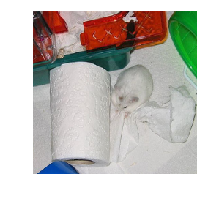

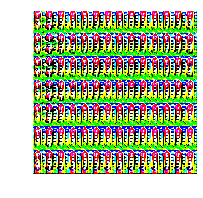

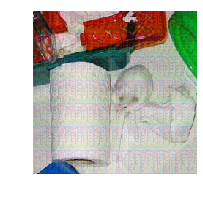

In [0]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data.cuda()
z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)

0.0 1.0
-2.1179039478302 2.549217700958252
0.0 1.0


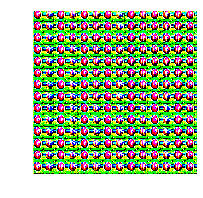

In [0]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)